In [5]:
import os
import sys
sys.path.append("/home/dux/")
sys.path.append("/home/dux/surface_sampling/sgmc_surf")

from mcmc import initialize_slab, spin_flip, mcmc_run, get_random_idx
from catkit.gen.adsorption import get_adsorption_sites

from ase.calculators.eam import EAM
from ase.calculators.lammpsrun import LAMMPS

import numpy as np

In [6]:
# Cu alat from https://www.copper.org/resources/properties/atomic_properties.html
Cu_alat = 3.6147
slab = initialize_slab(Cu_alat)

# get ALL the adsorption sites
# top should have connectivity 1, bridge should be 2 and hollow more like 4
coords, connectivity, sym_idx = get_adsorption_sites(slab, symmetry_reduced=False)
print(f"In pristine slab, there are a total of {len(connectivity)} sites")

# state of each vacancy in slab. for state > 0, it's filled, and that's the index of the adsorbate atom in slab
state = np.zeros(len(coords), dtype=int)

temp = 300
pot = 2

In pristine slab, there are a total of 64 sites


/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/catkit/gen/adsorption.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r1_topology = np.array(self.r1_topology)
/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/catkit/gen/adsorption.py:61: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  self.r2_topology = np.array(self.r2_topology)


In [7]:
from time import perf_counter

start = perf_counter()
# chem pot 0 to less complicate things
# temp in terms of kbT
# no cooling
num_sweeps = 100

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Cu_u3.eam']
}

potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Cu_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=True, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_sweeps=num_sweeps, temp=1, pot=0, alpha=0.99, slab=None, calc=lammps_calc)
stop = perf_counter()
print(f"Time taken = {stop - start} seconds")

INFO:Running with num_sweeps = 100, temp = 1, pot = 0, alpha = 0.99
INFO:initializing slab
INFO:there are 64 atoms 
INFO:using slab calc <ase.calculators.lammpsrun.LAMMPS object at 0x7fa4c438e5b0>
INFO:In pristine slab, there are a total of 64 sites
/home/dux/miniconda3/envs/mlenv/lib/python3.8/site-packages/ase/calculators/lammpsrun.py:379: UserWarning: semi-periodic ASE cell detected - translation to proper LAMMPS input cell might fail
  warnings.warn(
INFO:running for 64 iterations per run over a total of 100 runs
INFO:adsorbate is Cu
INFO:In sweep 1 out of 100
INFO:optim structure has Energy = -255.7271729023034
INFO:In sweep 2 out of 100
INFO:optim structure has Energy = -268.9221827356811
INFO:In sweep 3 out of 100
INFO:optim structure has Energy = -276.1994803601424
INFO:In sweep 4 out of 100
INFO:optim structure has Energy = -277.7212367442579
INFO:In sweep 5 out of 100
INFO:optim structure has Energy = -286.3339843822111
INFO:In sweep 6 out of 100
INFO:optim structure has Ener

Time taken = 82.42382896691561 seconds


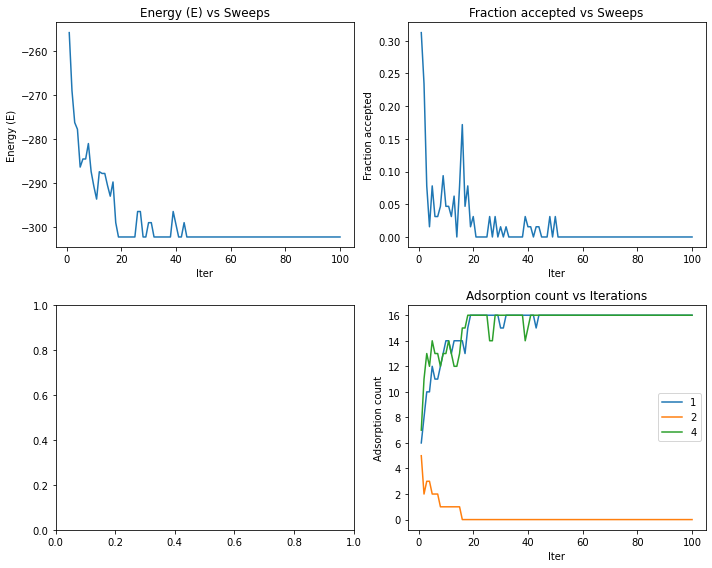

In [8]:
import matplotlib.pyplot as plt
runs = range(1, num_sweeps+1)
# do the plots
fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0, 0].plot(runs, energy_hist)
ax[0, 0].set_xlabel("Iter")
ax[0, 0].set_ylabel("Energy (E)")
ax[0, 0].set_title("Energy (E) vs Sweeps")

ax[0, 1].plot(runs, frac_accept_hist)
ax[0, 1].set_xlabel("Iter")
ax[0, 1].set_ylabel("Fraction accepted")
ax[0, 1].set_title("Fraction accepted vs Sweeps")

ax[1, 1].plot(runs, np.array(list(adsorption_count_hist.values())).T)
ax[1, 1].set_xlabel("Iter")
ax[1, 1].set_ylabel("Adsorption count")
ax[1, 1].legend(adsorption_count_hist.keys())
ax[1, 1].set_title("Adsorption count vs Iterations")

fig.show()
fig.tight_layout()

Coarse grain work

In [ ]:
from time import perf_counter

chem_pots = np.linspace(-4.0, 1.0, 9)
# chem_pots = [0] # do just one
num_runs = 100
all_energy_hist = np.random.rand(len(chem_pots), num_runs)
all_frac_accept_hist = np.random.rand(len(chem_pots), num_runs)
all_top_count_hist = np.random.rand(len(chem_pots), num_runs)
all_bridge_count_hist = np.random.rand(len(chem_pots), num_runs)
all_hollow_count_hist = np.random.rand(len(chem_pots), num_runs)

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Cu_u3.eam']
}
potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Cu_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=True, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

for i, chem_pot in enumerate(chem_pots):
    start = perf_counter()
    # chem pot 0 to less complicate things
    # temp in terms of kbT
    # 0.9 alpha for 20 runs
    history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=chem_pot, alpha=0.99, slab=None, calc=lammps_calc)
    
    stop = perf_counter()
    print(f"Time taken = {stop - start} seconds")
    all_energy_hist[i] = energy_hist
    all_frac_accept_hist[i] = frac_accept_hist
    all_top_count_hist[i] = adsorption_count_hist[1]
    all_bridge_count_hist[i] = adsorption_count_hist[2]
    all_hollow_count_hist[i] = adsorption_count_hist[4]

In [ ]:
import matplotlib.pyplot as plt

# do the plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]
ax[0].plot(runs, all_energy_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Energy (E)")
ax[0].set_title("Energy (E) vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_frac_accept_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Fraction accepted")
ax[1].set_title("Fraction accepted vs Iterations")
ax[1].legend(legends)

fig.show()
fig.tight_layout()
# fig.savefig("energy_per_spin")
# fig.savefig("sgmc_anneal_alpha_0.9_repeat1.png")

In [ ]:
import matplotlib.pyplot as plt

# do the plots
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]

ax[0].plot(runs, all_top_count_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Adsorption count")
ax[0].set_title("Top adsorption count vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_bridge_count_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Adsorption count")
ax[1].set_title("Bridge adsorption count vs Iterations")
ax[1].legend(legends)

ax[2].plot(runs, all_hollow_count_hist.T)
ax[2].set_xlabel("Iter")
ax[2].set_ylabel("Adsorption count")
ax[2].set_title("Hollow adsorption count vs Iterations")
ax[2].legend(legends)

fig.show()
fig.tight_layout()

Fine grain work

In [ ]:
from time import perf_counter

chem_pots = np.linspace(-3.125, -2.75, 5)
# chem_pots = [0] # do just one
num_runs = 500
all_energy_hist = np.random.rand(len(chem_pots), num_runs)
all_frac_accept_hist = np.random.rand(len(chem_pots), num_runs)
all_top_count_hist = np.random.rand(len(chem_pots), num_runs)
all_bridge_count_hist = np.random.rand(len(chem_pots), num_runs)
all_hollow_count_hist = np.random.rand(len(chem_pots), num_runs)

# use LAMMPS
parameters = {
    'pair_style': 'eam',
    'pair_coeff': ['* * Cu_u3.eam']
}
potential_file = os.path.join(os.environ["LAMMPS_POTENTIALS"], 'Cu_u3.eam')
lammps_calc = LAMMPS(files=[potential_file], keep_tmp_files=False, keep_alive=True, tmp_dir="/home/dux/surface_sampling/tmp_files")
lammps_calc.set(**parameters)

for i, chem_pot in enumerate(chem_pots):
    start = perf_counter()
    # chem pot 0 to less complicate things
    # temp in terms of kbT
    # 0.9 alpha for 20 runs
    history, energy_hist, frac_accept_hist, adsorption_count_hist = mcmc_run(num_runs=num_runs, temp=1, pot=chem_pot, alpha=0.99, slab=None, calc=lammps_calc)
    stop = perf_counter()
    print(f"Time taken = {stop - start} seconds")
    all_energy_hist[i] = energy_hist
    all_frac_accept_hist[i] = frac_accept_hist
    all_top_count_hist[i] = adsorption_count_hist[1]
    all_bridge_count_hist[i] = adsorption_count_hist[2]
    all_hollow_count_hist[i] = adsorption_count_hist[4]

In [ ]:
import matplotlib.pyplot as plt

# do the plots
fig, ax = plt.subplots(2, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]

ax[0].plot(runs, all_energy_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Energy (E)")
ax[0].set_title("Energy (E) vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_frac_accept_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Fraction accepted")
ax[1].set_title("Fraction accepted vs Iterations")
ax[1].legend(legends)

fig.show()
fig.tight_layout()
# fig.savefig("energy_per_spin")
# fig.savefig("sgmc_anneal_alpha_0.9_repeat1.png")

In [ ]:
import matplotlib.pyplot as plt

# do the plots
fig, ax = plt.subplots(3, 1, figsize=(10, 8))
runs = np.arange(1, num_runs+1)
legends = [f"\mu={mu}" for mu in chem_pots]

ax[0].plot(runs, all_top_count_hist.T)
ax[0].set_xlabel("Iter")
ax[0].set_ylabel("Adsorption count")
ax[0].set_title("Top adsorption count vs Iterations")
ax[0].legend(legends)

ax[1].plot(runs, all_bridge_count_hist.T)
ax[1].set_xlabel("Iter")
ax[1].set_ylabel("Adsorption count")
ax[1].set_title("Bridge adsorption count vs Iterations")
ax[1].legend(legends)

ax[2].plot(runs, all_hollow_count_hist.T)
ax[2].set_xlabel("Iter")
ax[2].set_ylabel("Adsorption count")
ax[2].set_title("Hollow adsorption count vs Iterations")
ax[2].legend(legends)

fig.show()
fig.tight_layout()